In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import scipy.stats as sp
import matplotlib.pyplot as plt
import json
import logging
import warnings
import os
import subprocess


warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)

logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)

def run_experiment(
    config_number,
    runs_max,
    min_mode_value,
    max_mode_value,
    weights,
    num_samples,
    num_chains,
    use_custom_chain_init=True,
    init_description="half in first mode, half in second mode"
):
     # === Experiment Setup ===
    samples_per_chain = num_samples // num_chains
    mean_range = [(i, -i) for i in range(min_mode_value, max_mode_value + 1)]

    # Create configuration folder
    config_folder = f"alt_config_{config_number}_with_{runs_max}_runs"
    os.makedirs(config_folder, exist_ok=True)

    # Save metadata
    metadata_filename = os.path.join(config_folder, f"metadata_config_{config_number}.json")
    experiment_metadata = {
        "config_number": config_number,
        "runs_max": runs_max,
        "min_mode": min_mode_value,
        "max_mode": max_mode_value,
        "num_samples": num_samples,
        "num_chains": num_chains,
        "samples_per_chain": samples_per_chain,
        "weights": weights,
        "use_custom_chain_init": use_custom_chain_init,
        "chain_initialization": init_description,
        "git_tag": get_git_tag(),
    }
    with open(metadata_filename, "w") as f:
        json.dump(experiment_metadata, f, indent=4)

    # Define fixed colors for each sampler
    sampler_colors = {
        "Metro": "blue",
        "HMC": "red",
        "DEMetro": "green"
    }

    # === Run the Experiment ===
    for run_id in range(1, runs_max + 1):
        print(f"\n===== Running Configuration {config_number} - Run {run_id} =====\n")

        run_folder = os.path.join(config_folder, f"run_{run_id}")
        results_folder = os.path.join(run_folder, "results")
        traces_folder = os.path.join(run_folder, "traces")
        plots_folder = os.path.join(run_folder, "plots")

        os.makedirs(run_folder, exist_ok=True)
        os.makedirs(results_folder, exist_ok=True)
        os.makedirs(traces_folder, exist_ok=True)
        os.makedirs(plots_folder, exist_ok=True)

        
        results = []

        for means in mean_range:

            #initvals = [
            #    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 1 starts near Mode 1
            #    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 2 starts near Mode 1
            #    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 3 starts near Mode 1
            #    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 4 starts near Mode 1
            #    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 5 starts near Mode 1
            #    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 6 starts near Mode 2
            #    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 7 starts near Mode 2
            #    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 8 starts near Mode 2
            #    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 9 starts near Mode 2
            #    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 10 starts near Mode 2
            #]

            initvals = [
                {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]} for _ in range(num_chains//2) # half the chains start near mode 1
            ] + [
                {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]} for _ in range(num_chains//2) # half the chains start near mode 2
            ]
            

            # Initialize model
            framework = WassersteinExample(means=means, weights=weights)
            
            # Generate IID samples
            iid_samples = framework.generate_iid_samples(num_samples=num_samples, means=means, weights=weights)
            
            # Run sampling for all samplers
            for sampler_name in ["Metro", "HMC", "DEMetro"]:
                
                print(f"Running for sampler {sampler_name} with means = {means}")
                trace = framework.run_sampling(sampler_name, num_samples=samples_per_chain, num_chains=num_chains, initvals=initvals)
                
                # Save trace to NetCDF file
                trace_filename = os.path.join(traces_folder, f"{sampler_name}_trace.nc")
                az.to_netcdf(trace, trace_filename)

                # Compute wasserstein distance
                ws_distance = framework.compute_wasserstein_distances(trace, iid_samples)
                # Compute R-hat
                r_hat = az.rhat(trace)["mixed_normal"].item()

                # Computes ESS
                ess = az.ess(trace)["mixed_normal"].item()


                results.append({
                    "means": means,
                    "sampler": sampler_name,
                    "wasserstein_distance": ws_distance,
                    "r_hat": r_hat,
                    "ess": ess
                })


        # Convert results to DataFrame
        df_results = pd.DataFrame(results)

        # Extract mode distances (first value of the tuple in "means" column)
        df_results["mode_distance"] = df_results["means"].apply(lambda x: abs(x[0] - x[1]))

        # Sort results
        df_results = df_results.sort_values("mode_distance", ascending=False)

        # initialize plots for all samplers
        fig_ws, ax_ws = plt.subplots(figsize=(10, 6))
        fig_rhat, ax_rhat = plt.subplots(figsize=(10, 6))
        fig_ess, ax_ess = plt.subplots(figsize=(10, 6))

        # Iterate over all samplers and plot the results
        for sampler in df_results["sampler"].unique():
            
            df_sampler = df_results[df_results["sampler"] == sampler]

            # Save CSV files
            csv_filename = os.path.join(results_folder, f"{sampler}_results.csv")
            df_sampler.to_csv(csv_filename, index=False)


            # Plot Wasserstein Distance
            ax_ws.plot(df_sampler["mode_distance"], df_sampler["wasserstein_distance"], 
                marker="o", linestyle="-", label=sampler, 
                color=sampler_colors.get(sampler, "black"))

            # Plot R-hat values
            ax_rhat.plot(df_sampler["mode_distance"], df_sampler["r_hat"], 
                    marker="o", linestyle="-", label=sampler, 
                    color=sampler_colors.get(sampler, "black"))
            
            # Plot ESS values
            ax_ess.plot(df_sampler["mode_distance"], df_sampler["ess"], 
                    marker="o", linestyle="-", label=sampler, 
                    color=sampler_colors.get(sampler, "black"))

        
        # ===== Finalize and Save Wasserstein Plot =====
        ax_ws.set_xlabel("Mode Distance (|Mean1 - Mean2|)")
        ax_ws.set_ylabel("Wasserstein Distance")
        ax_ws.set_title("Wasserstein Distance vs Mode Distance for All Samplers")
        ax_ws.legend(title="Sampler")
        ax_ws.grid(True)
        plot_filename = os.path.join(plots_folder, f"Wasserstein_plot_run_{run_id}.pdf")
        fig_ws.savefig(plot_filename, bbox_inches="tight")
        plt.close(fig_ws)

        # ===== Finalize and Save R-hat Plot =====
        ax_rhat.set_xlabel("Mode Distance (|Mean1 - Mean2|)")
        ax_rhat.set_ylabel("R-hat")
        ax_rhat.set_title("R-hat vs Mode Distance for All Samplers")
        ax_rhat.legend(title="Sampler")
        ax_rhat.grid(True)
        rhat_plot_filename = os.path.join(plots_folder, f"R-hat_plot_run_{run_id}.pdf")
        fig_rhat.savefig(rhat_plot_filename, bbox_inches="tight")
        plt.close(fig_rhat)

        # ===== Finalize and Save ESS Plot =====
        ax_ess.set_xlabel("Mode Distance (|Mean1 - Mean2|)")
        ax_ess.set_ylabel("ESS")
        ax_ess.set_title("ESS vs Mode Distance for All Samplers")
        ax_ess.legend(title="Sampler")
        ax_ess.grid(True)
        ess_plot_filename = os.path.join(plots_folder, f"ESS_plot_run_{run_id}.pdf")
        fig_ess.savefig(ess_plot_filename, bbox_inches="tight")
        plt.close(fig_ess)


    print("\n===== All Runs Completed Successfully! =====\n")

    # ===== GLOBAL RESULTS FOLDER =====
    global_folder = os.path.join(config_folder, "global_results")
    os.makedirs(global_folder)

    global_results_folder = os.path.join(global_folder, "results")
    global_plots_folder = os.path.join(global_folder, "plots")

    os.makedirs(global_results_folder)
    os.makedirs(global_plots_folder)

    # Collect all results from all runs
    df_all_runs = []

    for run_id in range(1, runs_max + 1):
        run_folder = os.path.join(config_folder, f"run_{run_id}")
        results_folder = os.path.join(run_folder, "results")

        for sampler in ["Metro", "HMC", "DEMetro"]:
            csv_filename = os.path.join(results_folder, f"{sampler}_results.csv")
            df_run = pd.read_csv(csv_filename)
            df_run["run_id"] = run_id 
            df_run["sampler"] = sampler  
            df_all_runs.append(df_run)


    # Combine all results into a single data frame 
    df_all_runs = pd.concat(df_all_runs, ignore_index=True)

    # Ensure 'means' are stored as tuples
    df_all_runs["means"] = df_all_runs["means"].apply(eval)

    # Initialize global plots
    fig_ws, ax_ws = plt.subplots(figsize=(10, 6))
    fig_rhat, ax_rhat = plt.subplots(figsize=(10, 6))
    fig_ess, ax_ess = plt.subplots(figsize=(10, 6))

    for sampler in ["Metro", "HMC", "DEMetro"]:
        df_sampler = df_all_runs[df_all_runs["sampler"] == sampler]

        # Pivot tables for Wasserstein distance and R-hat
        df_ws = df_sampler.pivot_table(index="means", columns="run_id", values="wasserstein_distance")
        df_rhat = df_sampler.pivot_table(index="means", columns="run_id", values="r_hat")
        df_ess = df_sampler.pivot_table(index="means", columns="run_id", values="ess")

        # Rename columns for clarity
        df_ws.columns = [f"Run_ws_{col}" for col in df_ws.columns]
        df_rhat.columns = [f"Run_rhat_{col}" for col in df_rhat.columns]
        df_ess.columns = [f"Run_ess_{col}" for col in df_ess.columns]

        # Merge metrics into a single DataFrame
        df_combined = pd.concat([df_ws, df_rhat, df_ess], axis=1).reset_index()

        # Compute global averages
        ws_cols = [col for col in df_combined.columns if col.startswith("Run_ws")]
        rhat_cols = [col for col in df_combined.columns if col.startswith("Run_rhat")]
        ess_cols = [col for col in df_combined.columns if col.startswith("Run_ess")]

        df_combined["global_avg_ws"] = df_combined[ws_cols].mean(axis=1)    # notwendig hier noch .mean auszurechnen??
        df_combined["global_avg_rhat"] = df_combined[rhat_cols].mean(axis=1)
        df_combined["global_avg_ess"] = df_combined[ess_cols].mean(axis=1)

        # Calculate mode distance
        df_combined["mode_distance"] = df_combined["means"].apply(lambda x: abs(x[0] - x[1])) # hier notwendig die mode distance zu berechnen?

        # Plot global averages
        color = sampler_colors.get(sampler, "black")
        ax_ws.plot(df_combined["mode_distance"], df_combined["global_avg_ws"],
                marker="o", linestyle="-", label=sampler, color=color)
        ax_rhat.plot(df_combined["mode_distance"], df_combined["global_avg_rhat"],
                marker="o", linestyle="-", label=sampler, color=color)
        ax_ess.plot(df_combined["mode_distance"], df_combined["global_avg_ess"],
                marker="o", linestyle="-", label=sampler, color=sampler_colors.get(sampler, "black"))

        # Select just the global averages for saving
        df_global_avg = df_combined[["means", "mode_distance", "global_avg_ws", "global_avg_rhat", "global_avg_ess"]]

        # Save combined CSV for this sampler
        sampler_csv_filename = os.path.join(global_results_folder, f"Global_results_{sampler}.csv")
        df_global_avg.to_csv(sampler_csv_filename, index=False)

    # ===== Finalize and Save Global Wasserstein Plot =====
    ax_ws.set_xlabel("Mode Distance (|Mean1 - Mean2|)")
    ax_ws.set_ylabel("Average Wasserstein Distance")
    ax_ws.set_title(f"Global Averaged Wasserstein Distance ({runs_max} Runs)")
    ax_ws.legend(title="Sampler")
    ax_ws.grid(True)
    fig_ws.savefig(os.path.join(global_plots_folder, "Wasserstein_global_plot.pdf"), bbox_inches="tight")
    plt.close(fig_ws)

    # ===== Finalize and Save Global R-hat Plot =====
    ax_rhat.set_xlabel("Mode Distance (|Mean1 - Mean2|)")
    ax_rhat.set_ylabel("Average R-hat")
    ax_rhat.set_title(f"Global Averaged R-hat Values ({runs_max} Runs)")
    ax_rhat.legend(title="Sampler")
    ax_rhat.grid(True)
    fig_rhat.savefig(os.path.join(global_plots_folder, "Rhat_global_plot.pdf"), bbox_inches="tight")
    plt.close(fig_rhat)

    # ===== Finalize and Save Global ESS Plot =====
    ax_ess.set_xlabel("Mode Distance (|Mean1 - Mean2|)")
    ax_ess.set_ylabel("Average ESS")
    ax_ess.set_title(f"Global Averaged ESS ({runs_max} Runs)")
    ax_ess.legend(title="Sampler")
    ax_ess.grid(True)
    fig_ess.savefig(os.path.join(global_plots_folder, "ESS_global_plot.pdf"), bbox_inches="tight")
    plt.close(fig_ess)

    print(f"\n===== Configuration {config_number} Completed Successfully! =====\n")


class WassersteinExample:
    
    def __init__(self, means, weights=[1,1]):
        self.model = self._bimodal_posterior(weights, means)
    
    def _bimodal_posterior(self, weights, means):        
        with pm.Model() as model:
            
            # Mixture weights (equal probability for both components)
            w = pm.Dirichlet("w", a=np.array(weights))

            # Component distributions
            mu = pm.Normal.dist(means, 1)
            
            # Mixture distribution
            mixed_normal = pm.Mixture("mixed_normal", w=w, comp_dists=mu)

        return model
    


    def generate_iid_samples(self, means, num_samples=2000, weights=[1,1]):
        """
        Generate IID samples from the bimodal posterior directly.
        """
        # Flip a coin to choose which Gaussian to sample from
        #modes = np.random.choice(means, size=num_samples)
        # transform [4, 1] to [0.8, 0.2]
        weights = np.array(weights) / np.sum(weights)
        modes = np.random.choice(means, size=num_samples, p=weights)
        # Sample from N(mode, 1)
        iid_samples = np.random.normal(loc=modes, scale=1, size=num_samples)
       


        return iid_samples


    def run_sampling(self, 
                     sampler_name, 
                     num_samples=2000, 
                     tune=1000, 
                     num_chains=2, 
                     initvals=None):

        with self.model:

            # Define which sampler to use
            if sampler_name == "Metro":
                sampler = pm.Metropolis()
            elif sampler_name == "HMC":
                sampler = pm.NUTS()
            elif sampler_name == "DEMetro":
                sampler = pm.DEMetropolis()
            else:
                raise ValueError(f"Unknown sampler: {sampler_name}")


            trace = pm.sample(num_samples, tune=tune, step=sampler, initvals= initvals,chains=num_chains, return_inferencedata=True, progressbar=False)
        
        return trace
    


    def compute_wasserstein_distances(self, trace, iid_samples):
        
        ws_distance = sp.wasserstein_distance(trace.posterior["mixed_normal"].values.flatten(), iid_samples)

        return ws_distance
    

# Function to get the current git tag
def get_git_tag():
        try:
            tag = subprocess.check_output(["git", "describe", "--tags"], stderr=subprocess.DEVNULL).strip().decode()
            return tag
        except subprocess.CalledProcessError:
            return "No tag found"






In [3]:
configurations = [
    {
        "config_number": 1,
        "runs_max": 2,
        "min_mode_value": 4,
        "max_mode_value": 5,
        "weights": [1, 6],
        "num_samples": 100,
        "num_chains": 10,
    },
    {
        "config_number": 2,
        "runs_max": 3,
        "min_mode_value": 5,
        "max_mode_value": 6,
        "weights": [1, 3],
        "num_samples": 200,
        "num_chains": 4,
    },
    # Add more configurations as needed
]


for config in configurations:
    run_experiment(
        config_number=config["config_number"],
        runs_max=config["runs_max"],
        min_mode_value=config["min_mode_value"],
        max_mode_value=config["max_mode_value"],
        weights=config["weights"],
        num_samples=config["num_samples"],
        num_chains=config["num_chains"]
    )



===== Running Configuration 1 - Run 1 =====

Running for sampler Metro with means = (4, -4)
Running for sampler HMC with means = (4, -4)
Running for sampler DEMetro with means = (4, -4)
Running for sampler Metro with means = (5, -5)
Running for sampler HMC with means = (5, -5)
Running for sampler DEMetro with means = (5, -5)

===== Running Configuration 1 - Run 2 =====

Running for sampler Metro with means = (4, -4)
Running for sampler HMC with means = (4, -4)
Running for sampler DEMetro with means = (4, -4)
Running for sampler Metro with means = (5, -5)
Running for sampler HMC with means = (5, -5)
Running for sampler DEMetro with means = (5, -5)

===== All Runs Completed Successfully! =====


===== Configuration 1 Completed Successfully! =====


===== Running Configuration 2 - Run 1 =====

Running for sampler Metro with means = (5, -5)
Running for sampler HMC with means = (5, -5)
Running for sampler DEMetro with means = (5, -5)
Running for sampler Metro with means = (6, -6)
Running f

In [ ]:
#temporary code
# ===== CREATE GLOBAL AVERAGE PLOT FOR WS DISTANCE =====
plt.figure(figsize=(10, 6))

# ===== SAVE INDIVIDUAL CSVs FOR EACH SAMPLER =====
for sampler in ["Metro", "HMC", "DEMetro"]:
    df_sampler = df_all_runs[df_all_runs["sampler"] == sampler]

    # Pivot again for this specific sampler
    df_sampler_pivot = df_sampler.pivot_table(
        index="means", 
        columns="run_id", 
        values="wasserstein_distance"
    ).reset_index()

    # Rename run columns
    df_sampler_pivot.columns = ["means"] + [f"Run_{col}" for col in df_sampler_pivot.columns[1:]]

    # Compute global average for this sampler
    df_sampler_pivot["global_avg"] = df_sampler_pivot.iloc[:, 1:].mean(axis=1)

    # Extract mode distances
    df_sampler_pivot["mode_distance"] = df_sampler_pivot["means"].apply(lambda x: abs(x[0] - x[1]))

    # Plot the global average Wasserstein distances
    plt.plot(df_sampler_pivot["mode_distance"], df_sampler_pivot["global_avg"], 
             marker="o", linestyle="-", label=sampler, 
             color=sampler_colors.get(sampler, "black"))

    # Save sampler-specific CSV
    sampler_csv_filename = os.path.join(global_folder, f"Wasserstein_global_results_{sampler}.csv")
    df_sampler_pivot.to_csv(sampler_csv_filename, index=False)


# Label and save the global plot
plt.xlabel("Mode Distance (|Mean1 - Mean2|)")
plt.ylabel("Average Wasserstein Distance")
plt.title(f"Global Averaged Wasserstein Distance ({runs_max} Runs)")
plt.legend(title="Sampler")
plt.grid(True)

global_plot_filename = os.path.join(global_folder, "Wasserstein_global_plot.pdf")
plt.savefig(global_plot_filename, bbox_inches="tight")
plt.close()

# ===== CREATE GLOBAL AVERAGE PLOT FOR R-HAT =====
plt.figure(figsize=(10, 6))

for sampler in ["Metro", "HMC", "DEMetro"]:
    df_sampler = df_all_runs[df_all_runs["sampler"] == sampler]

    # Pivot table for R-hat values
    df_rhat_pivot = df_sampler.pivot_table(
        index="means",
        columns="run_id",
        values="r_hat"
    ).reset_index()

    # Rename run columns
    df_rhat_pivot.columns = ["means"] + [f"Run_{col}" for col in df_rhat_pivot.columns[1:]]
    
    # Compute global average for R-hat
    df_rhat_pivot["global_avg_rhat"] = df_rhat_pivot.iloc[:, 1:].mean(axis=1)
    df_rhat_pivot["mode_distance"] = df_rhat_pivot["means"].apply(lambda x: abs(x[0] - x[1]))

    # Plot global average R-hat
    plt.plot(df_rhat_pivot["mode_distance"], df_rhat_pivot["global_avg_rhat"],
             marker="o", linestyle="-", label=sampler, color=sampler_colors.get(sampler, "black"))

    # Save global R-hat CSV
    rhat_csv_filename = os.path.join(global_folder, f"Rhat_global_results_{sampler}.csv")
    df_rhat_pivot.to_csv(rhat_csv_filename, index=False)

# Label and save the global R-hat plot
plt.xlabel("Mode Distance (|Mean1 - Mean2|)")
plt.ylabel("Average R-hat")
plt.title(f"Global Averaged R-hat Values ({runs_max} Runs)")
plt.legend(title="Sampler")
plt.grid(True)

global_rhat_plot_filename = os.path.join(global_folder, "Rhat_global_plot.pdf")
plt.savefig(global_rhat_plot_filename, bbox_inches="tight")
plt.close()


In [7]:
# new code to test

# ===== COMBINE ALL RUN RESULTS INTO A SINGLE DATAFRAME =====
df_all_runs = pd.concat(df_all_runs, ignore_index=True)

# Ensure 'means' are stored as tuples
df_all_runs["means"] = df_all_runs["means"].apply(eval)

# Initialize global plots
fig_ws, ax_ws = plt.subplots(figsize=(10, 6))
fig_rhat, ax_rhat = plt.subplots(figsize=(10, 6))

for sampler in ["Metro", "HMC", "DEMetro"]:
    df_sampler = df_all_runs[df_all_runs["sampler"] == sampler]

    # Pivot tables for Wasserstein distance and R-hat
    df_ws = df_sampler.pivot_table(index="means", columns="run_id", values="wasserstein_distance")
    df_rhat = df_sampler.pivot_table(index="means", columns="run_id", values="r_hat")

    # Rename columns for clarity
    df_ws.columns = [f"Run_ws_{col}" for col in df_ws.columns]
    df_rhat.columns = [f"Run_rhat_{col}" for col in df_rhat.columns]

    # Merge both metrics into a single DataFrame
    df_combined = pd.concat([df_ws, df_rhat], axis=1).reset_index()

    # Compute global averages
    ws_cols = [col for col in df_combined.columns if col.startswith("Run_ws")]
    rhat_cols = [col for col in df_combined.columns if col.startswith("Run_rhat")]

    df_combined["global_avg_ws"] = df_combined[ws_cols].mean(axis=1)
    df_combined["global_avg_rhat"] = df_combined[rhat_cols].mean(axis=1)

    # Calculate mode distance
    df_combined["mode_distance"] = df_combined["means"].apply(lambda x: abs(x[0] - x[1]))

    # Plot global averages
    color = sampler_colors.get(sampler, "black")
    ax_ws.plot(df_combined["mode_distance"], df_combined["global_avg_ws"],
               marker="o", linestyle="-", label=sampler, color=color)
    ax_rhat.plot(df_combined["mode_distance"], df_combined["global_avg_rhat"],
                 marker="o", linestyle="-", label=sampler, color=color)

    # Save combined CSV for this sampler
    sampler_csv_filename = os.path.join(global_folder, f"Global_results_{sampler}.csv")
    df_combined.to_csv(sampler_csv_filename, index=False)

# ===== Finalize and Save Global Wasserstein Plot =====
ax_ws.set_xlabel("Mode Distance (|Mean1 - Mean2|)")
ax_ws.set_ylabel("Average Wasserstein Distance")
ax_ws.set_title(f"Global Averaged Wasserstein Distance ({runs_max} Runs)")
ax_ws.legend(title="Sampler")
ax_ws.grid(True)
fig_ws.savefig(os.path.join(global_folder, "Wasserstein_global_plot.pdf"), bbox_inches="tight")
plt.close(fig_ws)

# ===== Finalize and Save Global R-hat Plot =====
ax_rhat.set_xlabel("Mode Distance (|Mean1 - Mean2|)")
ax_rhat.set_ylabel("Average R-hat")
ax_rhat.set_title(f"Global Averaged R-hat Values ({runs_max} Runs)")
ax_rhat.legend(title="Sampler")
ax_rhat.grid(True)
fig_rhat.savefig(os.path.join(global_folder, "Rhat_global_plot.pdf"), bbox_inches="tight")
plt.close(fig_rhat)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

(array([ 4.,  1.,  1.,  1.,  0.,  2., 10., 13., 17., 32., 25.,  4.,  1.,
        25., 20.,  9.,  9., 23.,  2.,  4.,  8.,  6.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  2.,  4.,
        11., 11., 22., 26., 84., 27., 87., 58., 64., 54., 71., 25., 84.,
        34., 11., 19., 18., 28., 24.,  2.,  5.,  6.]),
 array([-10.6245586 , -10.41238515, -10.2002117 ,  -9.98803824,
         -9.77586479,  -9.56369134,  -9.35151788,  -9.13934443,
         -8.92717098,  -8.71499753,  -8.50282407,  -8.29065062,
         -8.07847717,  -7.86630371,  -7.65413026,  -7.44195681,
         -7.22978335,  -7.0176099 ,  -6.80543645,  -6.59326299,
         -6.38108954,  -6.16891609,  -5.95674263,  -5.74456918,
         -5.53239573,  -5.32022228,  -5.10804882, 

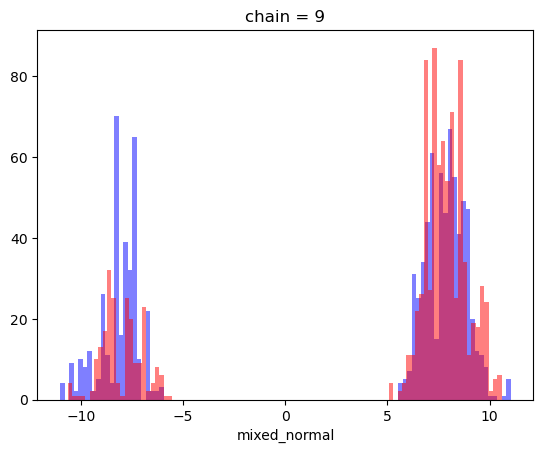

In [3]:
traces['DEMetro'].sel(chain=0).stack(sample=("draw")).posterior["mixed_normal"].plot.hist(bins=100, alpha=0.5, label="Metro", color="blue")
traces['DEMetro'].sel(chain=9).stack(sample=("draw")).posterior["mixed_normal"].plot.hist(bins=100, alpha=0.5, label="Metro", color="red")


In [ ]:

fig, ax = plt.subplots(2, 3, figsize=(15, 5))

for i, (sampler_name, trace) in enumerate(traces.items()):
    ax[0][i].hist(trace.posterior["mixed_normal"].values.flatten(), bins=50, alpha=0.5, label=sampler_name)
    ax[0][i].hist(iid_samples, bins=50, alpha=0.5, label="IID Samples")
    ax[0][i].set_title(sampler_name)
    ax[0][i].legend()

    


In [ ]:

# r hat computation

ws_results = {}

traces = {}

r_hat_values = {}

for sampler_name in ["Metro","HMC","DEMetro"]:
    trace = framework.run_sampling(
        sampler_name,
        num_samples= samples_per_chain,
        num_chains=num_chains,
        #initvals=initvals,
        )
    ws_distance = framework.compute_wasserstein_distances(trace, iid_samples)
    ws_results[sampler_name] = ws_distance
    r_hat_value = az.rhat(trace)["mixed_normal"].item()
    r_hat_values[sampler_name] = r_hat_value

    print("dim der samples")
    print(trace.posterior["mixed_normal"].values.shape)

    print("dim der iid samples")
    print(iid_samples.shape)

    traces[sampler_name] = trace
    print(f"{sampler_name}: Wasserstein Distance = {ws_distance:.4f}")
    print(f"{sampler_name}: R-hat value = {r_hat_value:.4f}")



# Sort results
ranked_ws = sorted(ws_results.items(), key=lambda x: x[1])
ranked_r_hat = sorted(r_hat_values.items(), key=lambda x: x[1])


# Print ranked results
print("\n### Ranked Sampler Performance ###")
for rank, (sampler_name, ws_distance) in enumerate(ranked_ws, 1):
    print(f"{rank}. {sampler_name}: {ws_distance:.4f}")

print("\n### Ranked Sampler R-hat Values ###")
for rank, (sampler_name, r_hat) in enumerate(ranked_r_hat, 1):
    print(f"{rank}. {sampler_name}: {r_hat}")

In [ ]:
#initvals = [
#    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 1 starts near Mode 2
#    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 2 starts near Mode 2
#    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]}, # Chain 3 starts near Mode 2
#    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]}, # Chain 4 starts near Mode 2
#    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 5 starts near Mode 2
#    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 6 starts near Mode 2
#    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]}, # Chain 7 starts near Mode 2
#    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]}, # Chain 8 starts near Mode 2
#    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 9 starts near Mode 2
#    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 10 starts near Mode 2
#]

